In [25]:
import torch
import torch.nn as nn
from torchvision import transforms
from utils import cifar10p1_OOD
import matplotlib.pylab as plt
%matplotlib inline

In [5]:
input_size = 32
train_mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
train_std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

class Args():
    pass 


args = Args()
args.dataset = 'CIFAR10_1'
args.imagesetdir = '/home/tt2684/Research/Data/CIFAR10_1/'
args.batch_size=256
args.workers = 4

transform_train = transforms.Compose([
transforms.Resize(input_size),
transforms.RandomCrop(input_size, padding=4),
# transforms.RandomAffine(degrees=30),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize(train_mean, train_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])


test_dataset = getattr(cifar10p1_OOD, args.dataset)(root=args.imagesetdir, download=True, transform=transform_test)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, drop_last=True)

/home/tt2684/Research/Data/CIFAR10_1/cifar10.1-labels.npy
Files already downloaded and verified
/home/tt2684/Research/Data/CIFAR10_1/cifar10.1-labels.npy


In [11]:
dataiter = iter(val_loader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


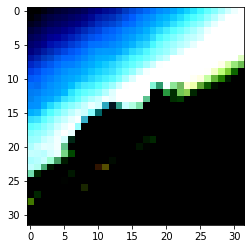

In [29]:
plt.imshow(images[3].permute([1,2,0]).numpy())

In [ ]:
import torch
import torch.nn as nn

In [4]:
import torchvision.models as models

In [5]:
resnet18 = models.resnet18()

In [6]:
from models import custom_resnets as custom_models

In [7]:
m = nn.Linear(4,3, bias=False)
m(torch.rand(4))

tensor([-0.3320,  0.0632, -0.0421], grad_fn=<SqueezeBackward3>)

In [8]:

class ReLUGrad(nn.Module):
    def __init__(self):
        super(ReLUGrad, self).__init__()
    def forward(self, grad_output, input):
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

In [9]:
m = nn.ReLU()
inputs = torch.rand(2,3)

b = ReLUGrad()
error = nn.Parameter(torch.tensor([1.1,2.1]), requires_grad=True)

In [10]:
m(inputs)

tensor([[0.1397, 0.7951, 0.6761],
        [0.0495, 0.2153, 0.5409]])

In [11]:
error.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

In [14]:
m = nn.BatchNorm2d(64)
inputs = torch.rand(1,64,32, 32)
outputs = m(inputs)

In [23]:
list(m.parameters())

[Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        requires_grad=True)]

## BN

In [1]:
class GBatchNorm2d(nn.Module):
    def __init__(self):
        super(GBatchNorm2d, self).__init__()
    def forward(self, grad_output, cache):
        #unfold the variables stored in cache
        xhat,gamma,xmu,ivar,sqrtvar,var,eps = cache

        #get the dimensions of the input/output
        N,D = dout.shape

        #step9
        dbeta = np.sum(dout, axis=0)
        dgammax = dout #not necessary, but more understandable

        #step8
        dgamma = np.sum(dgammax*xhat, axis=0)
        dxhat = dgammax * gamma

        #step7
        divar = np.sum(dxhat*xmu, axis=0)
        dxmu1 = dxhat * ivar

        #step6
        dsqrtvar = -1. /(sqrtvar**2) * divar

        #step5
        dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar

        #step4
        dsq = 1. /N * np.ones((N,D)) * dvar

        #step3
        dxmu2 = 2 * xmu * dsq

        #step2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)

        #step1
        dx2 = 1. /N * np.ones((N,D)) * dmu

        #step0
        dx = dx1 + dx2

        return dx, dgamma, dbeta




IndentationError: expected an indented block (<ipython-input-1-2b161b87d57e>, line 6)

In [ ]:
class MyBN1(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-5, momentum=0.1,
                 affine=True, track_running_stats=True):
        super(MyBN1, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)

    def forward(self, input):
        self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        # calculate running estimates
        if self.training:
            mean = input.mean([0, 2, 3])
            var = input.var([0, 2, 3], unbiased=False)
            n = input.numel() / input.size(1)
            with torch.no_grad():
                self.running_mean = exponential_average_factor * mean\
                    + (1 - exponential_average_factor) * self.running_mean
                # update running_var with unbiased var
                self.running_var = exponential_average_factor * var * n / (n - 1)\
                    + (1 - exponential_average_factor) * self.running_var
            mean = mean.view(1, -1, 1, 1)
            var = var.view(1, -1, 1, 1)
                
        else:
            mean = self.running_mean
            var = self.running_var
        weight = self.weight.view(1, -1, 1, 1)
        bias = self.bias.view(1, -1, 1, 1)

        output = MyBNFunc.apply(input, mean, var, weight, bias, self.eps)
        
        return output

def mysum(tensor):
    return tensor.sum((0,2,3),keepdim=True)
class MyBNFunc(Function):
    @staticmethod
    def forward(ctx, input, avg, var, gamma, beta, eps):
        ctx.avg = avg
        ctx.var = var
        ctx.eps = eps
        ctx.shape = input.shape
        output = input - avg
        scale = 1 / torch.sqrt(var + eps)
        output = output * scale
        ctx.save_for_backward(input, gamma, beta, output, scale)
        output = output * gamma + beta
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        input, gamma, beta, output, scale = ctx.saved_tensors
        avg = ctx.avg
        var = ctx.var
        eps = ctx.eps
        B, C, H, W = ctx.shape

        dL_dxi_hat = grad_output * gamma
        dl_dvar = mysum(dL_dxi_hat) * (input - avg) * -0.5 * scale * scale * scale
        dl_davg = mysum(dL_dxi_hat * -1.0 * scale) + dl_dvar * mysum(-2.0 * (input - avg)) / (B * H * W)
        dL_dxi = dL_dxi_hat * scale + dl_dvar * 2.0 * (input - avg) / (B*H*W)  + dl_davg / (B*H*W)
        dL_dgamma = (grad_output * output).sum((0, 2, 3), keepdim=True) 
        dL_dbeta = (grad_output).sum((0, 2, 3), keepdim=True)
        return dL_dxi, dl_davg, dl_dvar, dL_dgamma, dL_dbeta, None


In [24]:
custom_models.asymresnet18()

AsymResNet(
  (conv1): AsymmetricFeedbackConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): AsymmetricFeedbackConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): AsymmetricFeedbackConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (1): BasicBlock(
      (conv1): AsymmetricFeedbackConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): AsymmetricFeedbackConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [25]:
custom_models.asymresnetT18()

AsymResNetT(
  (conv2): AsymmetricFeedbackConvTranspose2d(10, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer4): Sequential(
    (0): BasicBlockT(
      (conv1): AsymmetricFeedbackConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): AsymmetricFeedbackConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (1): BasicBlockT(
      (conv1): AsymmetricFeedbackConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (conv2): AsymmetricFeedbackConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (upsample): AsymmetricFeedbackConvTranspose2d(